In [3]:
import pandas as pd
from datetime import datetime
from langdetect import detect
import math
from tqdm.notebook import tqdm

In [4]:
# import libraries and run a few checks
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import scipy.stats as stats
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set(palette='Paired', style='white')

import warnings 
warnings.filterwarnings('ignore')

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


# utility function to save figures for presentation
# use it like save_fig('figure_name')
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# util to reduce memory usage
## From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:.2f} Mb ({1-end_mem/start_mem:.2%} reduction)')
    return df


# summarize outliers for numerical columns
def summarize_outliers(df_num, n_std=3):
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    margin = data_std * n_std
    lower, upper = data_mean - margin, data_mean + margin
    
    res = pd.DataFrame(df_num.apply(axis=0, func=lambda x: np.sum(x < lower[x.name])), columns=['n_lower'])
    res['n_higher'] = df_num.apply(axis=0, func=lambda x: np.sum(x > upper[x.name])).values
    res['n_outliers'] = res['n_lower'] + res['n_higher']
    res['%_outliers'] = (res['n_outliers'] / df_num.notnull().sum() * 100).round(2)

    return res 

In [7]:
calendar_df = pd.read_csv('calendar.csv',  encoding="utf-8")
listings_df = pd.read_csv('listings.csv',  encoding="utf-8")
listings_summary_df = pd.read_csv('listings_summary.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews.csv',  encoding="utf-8")
reviews_summary_df = pd.read_csv('reviews_summary.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews.csv',  encoding="utf-8")

dfs = {'Calendar': calendar_df,
      'Listings':listings_df,
      'Listings Summary': listings_summary_df,
      'Reviews':reviews_df,
      'Reviews Summary': reviews_summary_df}


### Know the data
Understand the semantics and structure of the data set, e.g., the meaning of each column / attribute, the relationship between multiple tables, especially the referential relationship among the data

Identify the data type and domain of each attribute, and relevant constraints

Analyze the data and obtain statistics of data (e.g., size, range, distribution; dictionary size of text data; languages in text; etc.)

In [6]:
for k,v in dfs.items():
    v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6231645 entries, 0 to 6231644
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 332.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17074 non-null  int64  
 1   listing_url                                   17074 non-null  object 
 2   scrape_id                                     17074 non-null  int64  
 3   last_scraped                                  17074 non-null  object 
 4  

In [7]:
def detectlang(x):
    x = str(x)
    try:
        lang = detect(x)
    except:
        lang = "unknown"
    return lang

def dollar_num(x):
    x = str(x)
    if x.startswith('$'):
        return round(float(x.strip('$').replace(",","")),2)
    
def percent_num(x):
    x = str(x)
    if x.endswith('%'):
        return round(float(x.strip('%')))

In [8]:
def getdatasummary(listings_df):
    collist = []
    typelist = []
    notnulllist = []
    lengthlist = []
    numroundlist = []
    langlist = []

    tlist = tqdm(listings_df.columns.tolist())

    for col in tlist:

        if listings_df[col].count() == 0:
            col = col
            coltype = 'empty'
            notnull = ''
            length = ''
            numround = ''
            lang = ''
        else:
            if listings_df[col].count() == listings_df.shape[0]:
                notnull = "notnull"
            else:
                notnull = ""


            if listings_df[col].dtype == 'int64' or listings_df[col].dtype == 'float64':
                coltype = 'Numeric'
                length = math.ceil(max(listings_df[col].map(str).apply(len))/10)*10
                numround = 0
                lang = ""

            elif 'price' in col and listings_df[col].dtype == 'object':
                listings_df[col] = listings_df[col].apply(lambda x: dollar_num(x))
                coltype = 'Numeric'
                length = 5
                numround = 2
                lang = ""

            elif 'rate' in col and listings_df[col].dtype == 'object':
                listings_df[col] = listings_df[col].apply(lambda x: percent_num(x))
                coltype = 'Numeric'
                length = 3
                numround = 0
                lang = ""

            elif 'date' in col and listings_df[col].dtype == 'object':
                coltype = 'Date'
                length = ""
                numround = ""
                lang = ""

            elif 'True' in listings_df[col].astype(str).str.match(r'\d{4}-\d{2}-\d{2}').astype(str).unique().tolist() and listings_df[col].dtype == 'object':
                coltype = 'Date'
                length = ""
                numround = ""
                lang = ""

            else:
                if max(listings_df[col].map(str).apply(len)) == 1 and listings_df[col].nunique() == 2:
                    coltype = 'Bool/bit/numeric/varchar'
                    length = 1
                    numround = ""
                    lang = ""
                elif listings_df[col].nunique() < 10:
                    coltype = 'Varchar'
                    length = math.ceil(max(listings_df[col].map(str).apply(len))/10)*10
                    numround = ""
                    lang = ""
                elif any(ele in col for ele in ['url', 'type', 'amenities', 'bathrooms']):
                    coltype = 'Varchar'
                    length = math.ceil(max(listings_df[col].map(str).apply(len))/10)*10
                    numround = ""
                    lang = ""
                else: 
                    lang = listings_df[col].apply(detectlang).unique().tolist()
                    try:
                        lang.remove("unknown")
                    except:
                        pass
                    if len(lang) > 1:
                        coltype = 'Nvarchar'
                    else:
                        coltype = 'Varchar'
                    length = math.ceil(max(listings_df[col].map(str).apply(len))/10)*10
                    numround = ""

        collist.append(col)
        typelist.append(coltype)
        notnulllist.append(notnull)
        lengthlist.append(length)
        numroundlist.append(numround)
        langlist.append(lang)

    data = {'Attribute': collist, 
            'Type': typelist, 
            'Size constraint': lengthlist,
            'Numerical Round off': numroundlist,
            'Null constraint': notnulllist,
            'language': langlist} 

    listings_df_summary = pd.DataFrame(data)
    return listings_df_summary

In [10]:
pd.set_option('display.max_rows', 100)
listings_df_summary = getdatasummary(listings_df)
listings_df_summary

  0%|          | 0/74 [00:00<?, ?it/s]

,Attribute,Type,Size constraint,Numerical Round off,Null constraint,language
0,id,Numeric,20,0,notnull,
1,listing_url,Varchar,50,,notnull,
2,scrape_id,Numeric,20,0,notnull,
3,last_scraped,Date,,,notnull,
4,name,Nvarchar,260,,,"[en, tl, pt, th, no, de, ro, id, af, fi, nl, s..."
5,description,Nvarchar,1000,,,"[en, th, tl, fr, ja, nl, vi, et, af, zh-cn, ko..."
6,neighborhood_overview,Nvarchar,1000,,,"[en, tl, no, th, af, fi, id, da, ca, ro, zh-cn..."
7,picture_url,Varchar,130,,notnull,
8,host_id,Numeric,10,0,notnull,
9,host_url,Varchar,50,,notnull,


In [9]:
calendar_df_summary = getdatasummary(calendar_df)
calendar_df_summary

  0%|          | 0/7 [00:00<?, ?it/s]

,Attribute,Type,Size constraint,Numerical Round off,Null constraint,language
0,listing_id,Numeric,20,0,notnull,
1,date,Date,,,notnull,
2,available,Bool/bit/numeric/varchar,1,,notnull,
3,price,Numeric,5,2,notnull,
4,adjusted_price,Numeric,5,2,notnull,
5,minimum_nights,Numeric,10,0,,
6,maximum_nights,Numeric,20,0,,


In [19]:
listings_summary_df_summary = getdatasummary(listings_summary_df)
listings_summary_df_summary

  0%|          | 0/18 [00:00<?, ?it/s]

,Attribute,Type,Size constraint,Numerical Round off,Null constraint,language
0,id,Numeric,20,0,notnull,
1,name,Nvarchar,260,,,"[de, pt, en, tl, th, no, ro, af, et, id, nl, f..."
2,host_id,Numeric,10,0,notnull,
3,host_name,Nvarchar,40,,,"[sw, de, fi, so, id, tl, nl, sq, th, cy, et, e..."
4,neighbourhood_group,empty,,,,
5,neighbourhood,Nvarchar,20,,notnull,"[tl, id, en, vi, sw, de, so, af, cy]"
6,latitude,Numeric,20,0,notnull,
7,longitude,Numeric,20,0,notnull,
8,room_type,Varchar,20,,notnull,
9,price,Numeric,10,0,notnull,


In [20]:
reviews_df_summary = getdatasummary(reviews_df)
reviews_df_summary

  0%|          | 0/6 [00:00<?, ?it/s]

,Attribute,Type,Size constraint,Numerical Round off,Null constraint,language
0,listing_id,Numeric,20,0,notnull,
1,id,Numeric,20,0,notnull,
2,date,Date,,,notnull,
3,reviewer_id,Numeric,10,0,notnull,
4,reviewer_name,Nvarchar,50,,,"[sw, no, de, id, fr, pl, vi, cy, it, ca, tr, e..."
5,comments,Nvarchar,6580,,,"[en, th, ru, zh-cn, cs, es, fr, de, so, ko, hr..."


In [21]:
reviews_summary_df_summary = getdatasummary(reviews_summary_df)
reviews_summary_df_summary

  0%|          | 0/2 [00:00<?, ?it/s]

,Attribute,Type,Size constraint,Numerical Round off,Null constraint,language
0,listing_id,Numeric,20,0,notnull,
1,date,Date,,,notnull,


In [23]:
# save summary to csv
dfs1 = {'Calendar': calendar_df_summary,
      'Listings':listings_df_summary,
      'Listings Summary': listings_summary_df_summary,
      'Reviews':reviews_df_summary,
      'Reviews Summary': reviews_summary_df_summary}
for k,v in dfs1.items():
    v.to_csv('{}_table.csv'.format(k), index = False, columns = v.columns.tolist())

In [180]:
#Check for primary key
def checkkey(name, df):
    print('='*50 + name + '='*50 )
    print('rows: {}'.format(df.shape[0]))
    for col in df.columns.tolist():
        print('{}: {}/{}'.format(col, df[col].nunique(), df[col].count()))

    
for k,v in dfs.items():
    checkkey(k,v)

==================================================Calendar==================================================
rows: 6231645
listing_id: 17073/6231645
date: 366/6231645
available: 2/6231645
price: 6957/6231645
adjusted_price: 7099/6231645
minimum_nights: 81/6231643
maximum_nights: 131/6231643
==================================================Listings==================================================
rows: 17074
id: 17074/17074
listing_url: 17074/17074
scrape_id: 1/17074
last_scraped: 2/17074
name: 16089/17065
description: 13298/16169
neighborhood_overview: 6002/9459
picture_url: 15799/17074
host_id: 7639/17074
host_url: 7639/17074
host_name: 5991/17072
host_since: 2807/17072
host_location: 632/17030
host_about: 3305/9833
host_response_time: 4/11445
host_response_rate: 54/11445
host_acceptance_rate: 70/10295
host_is_superhost: 2/17072
host_thumbnail_url: 7557/17072
host_picture_url: 7557/17072
host_neighbourhood: 89/9812
host_listings_count: 74/17072
host_total_listings_count: 74/17072
ho

In [31]:
# listing_id and data make up primary key for Calendar
se = calendar_df['listing_id'].map(str)+calendar_df['date'].map(str)
se.nunique()

6231645

In [34]:
# there are no primary key in reviews_summary
se = reviews_summary_df['listing_id'].map(str)+'-'+reviews_summary_df['date'].map(str)
se.nunique()

244361

### primary key for current data

calendar: listing_id, date

listings: id

listings_summary: id

reviews: id

reviews_summary: -

### Referential relationship

calendar (listing_id) --> listings (id)

listings_summary (id) --> listings (id)

reviews (listing_id) --> listings (id)

## Statisics of data

### Calendar

In [45]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6231645 entries, 0 to 6231644
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           float64
 4   adjusted_price  float64
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 332.8+ MB


In [46]:
num_cols = calendar_df.describe().columns.to_list()[:-1]
calendar_df.describe()

,listing_id,price,adjusted_price,minimum_nights,maximum_nights
count,6.231645e+06,6.231645e+06,6.231645e+06,6.231643e+06,6.231643e+06
mean,4.552811e+16,2.380776e+03,2.363647e+03,1.412625e+01,1.706353e+06
std,1.600215e+17,1.382413e+04,1.381745e+04,4.561988e+01,6.049433e+07
min,2.793400e+04,2.520000e+02,1.650000e+02,1.000000e+00,1.000000e+00
25%,1.935669e+07,8.000000e+02,8.000000e+02,1.000000e+00,3.650000e+02
50%,3.245164e+07,1.215000e+03,1.200000e+03,1.000000e+00,1.125000e+03
75%,4.146112e+07,2.000000e+03,2.000000e+03,7.000000e+00,1.125000e+03
max,6.525392e+17,1.500000e+06,1.500000e+06,1.125000e+03,2.147484e+09


In [49]:
cat_cols = calendar_df.describe(include=['O']).columns.to_list()
calendar_df.describe(include=['O'])

,date,available
count,6231645,6231645
unique,366,2
top,2022-12-20,t
freq,17073,4329257


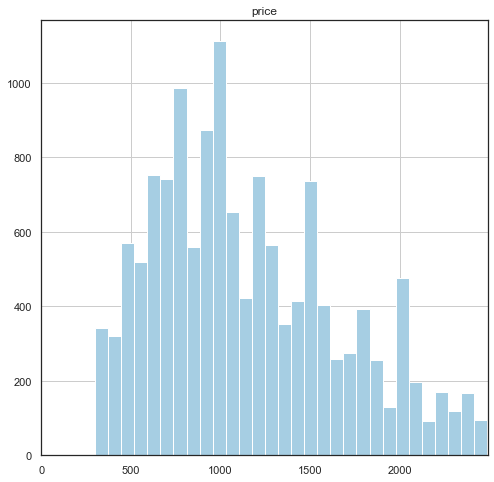

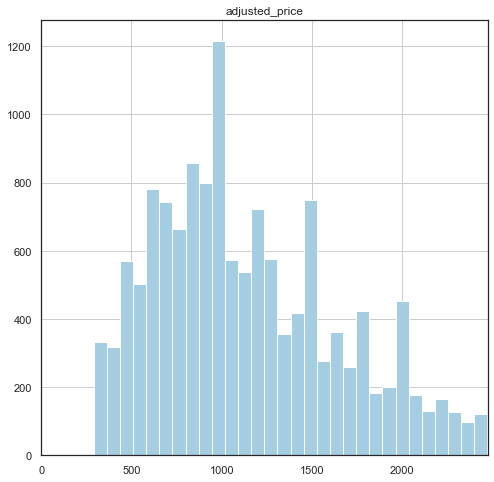

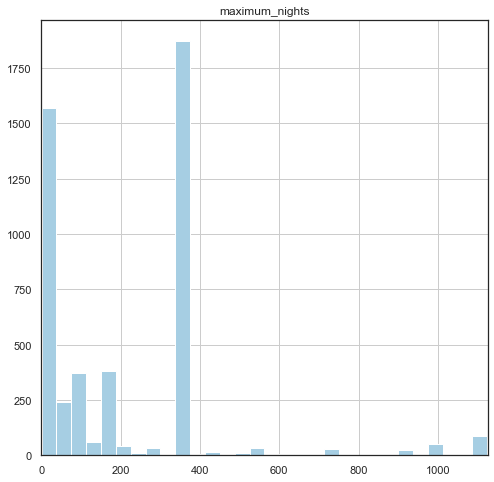

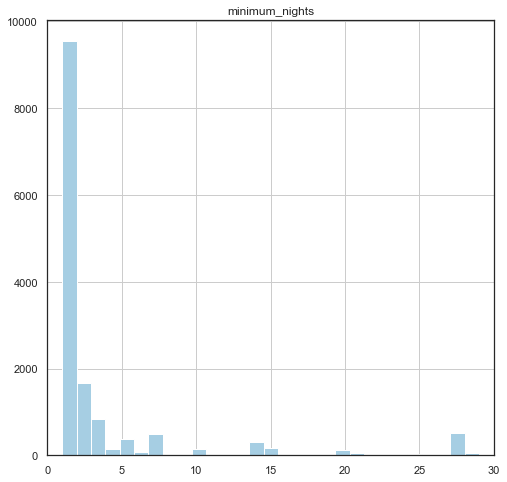

In [81]:
# numerical features
for col in ['price', 'adjusted_price', 'maximum_nights']:
    fig = plt.figure(figsize = (8,8))
    ax = fig.gca()
    grouped = calendar_df.groupby(['listing_id'])[col].mean()
    filt = grouped.loc[lambda x : x < calendar_df[col].quantile([0.8]).values[0]]
    filt.hist(ax = ax, bins=30)
    ax.set_xlim(0,calendar_df[col].quantile([0.8]).values[0])
    ax.set_title(col)
    
for col in ['minimum_nights']:
    fig = plt.figure(figsize = (8,8))
    ax = fig.gca()
    grouped = calendar_df.groupby(['listing_id'])[col].mean()
    filt = grouped.loc[lambda x : x < calendar_df[col].quantile([0.90]).values[0]]
    filt.hist(ax = ax, bins=30)
    ax.set_xlim(0,calendar_df[col].quantile([0.90]).values[0])
    ax.set_title(col)
#save_fig("num_cols_distribution_plots")

Text(0.5, 1.0, 'available')

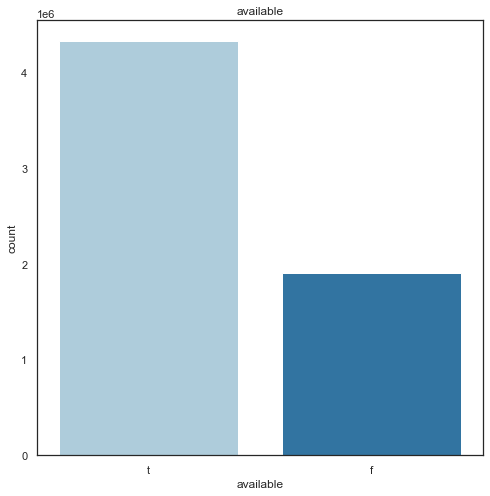

In [88]:
#cat features
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.countplot(x=calendar_df['available'], ax=ax)
ax.set_title('available')

### Listings summary

In [83]:
listings_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              17074 non-null  int64  
 1   name                            17065 non-null  object 
 2   host_id                         17074 non-null  int64  
 3   host_name                       17072 non-null  object 
 4   neighbourhood                   17074 non-null  object 
 5   latitude                        17074 non-null  float64
 6   longitude                       17074 non-null  float64
 7   room_type                       17074 non-null  object 
 8   price                           17074 non-null  int64  
 9   minimum_nights                  17074 non-null  int64  
 10  number_of_reviews               17074 non-null  int64  
 11  last_review                     10012 non-null  object 
 12  reviews_per_month               

In [84]:
num_cols = listings_summary_df.describe().columns.to_list()[:-1]
listings_summary_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.707400e+04,1.707400e+04,17074.000000,17074.000000,1.707400e+04,17074.000000,17074.000000,10012.000000,17074.000000,17074.000000,17074.000000
mean,4.552544e+16,1.445663e+08,13.746988,100.561440,2.262178e+03,14.181797,14.445590,0.564038,11.953497,253.558451,1.187771
std,1.600219e+17,1.163357e+08,0.050114,0.054145,1.332705e+04,46.362005,37.094589,0.812025,25.137223,123.933499,3.898571
min,2.793400e+04,5.892000e+04,13.527300,100.310620,0.000000e+00,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.935684e+07,4.028381e+07,13.719140,100.529980,7.900000e+02,1.000000,0.000000,0.070000,1.000000,161.000000,0.000000
50%,3.245198e+07,1.214842e+08,13.738555,100.561620,1.200000e+03,1.000000,1.000000,0.250000,4.000000,328.000000,0.000000
75%,4.146223e+07,2.293555e+08,13.763040,100.588130,2.000000e+03,7.000000,10.000000,0.770000,11.000000,365.000000,0.000000
max,6.525392e+17,4.647000e+08,13.973550,100.923440,1.500000e+06,1125.000000,1119.000000,19.420000,195.000000,365.000000,112.000000


In [85]:
cat_cols = listings_summary_df.describe(include=['O']).columns.to_list()
listings_summary_df.describe(include=['O'])

,name,host_name,neighbourhood,room_type,last_review
count,17065,17072,17074,17074,10012
unique,16089,5991,50,4,1859
top,New! La Chada Night Market studio 2PPL near MRT,Curry,Vadhana,Entire home/apt,2022-06-05
freq,45,195,2117,9224,118


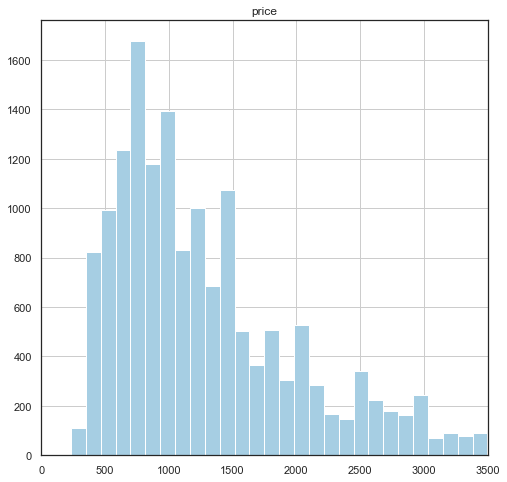

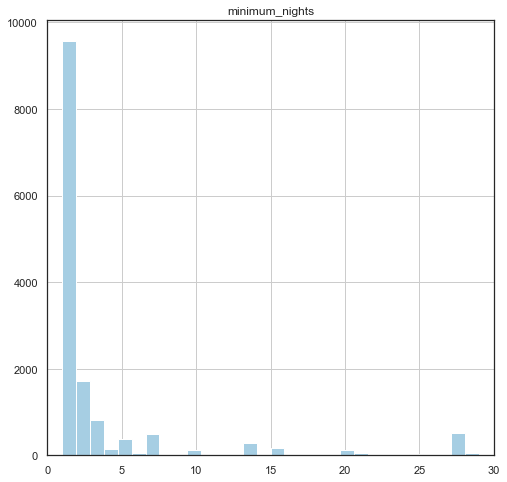

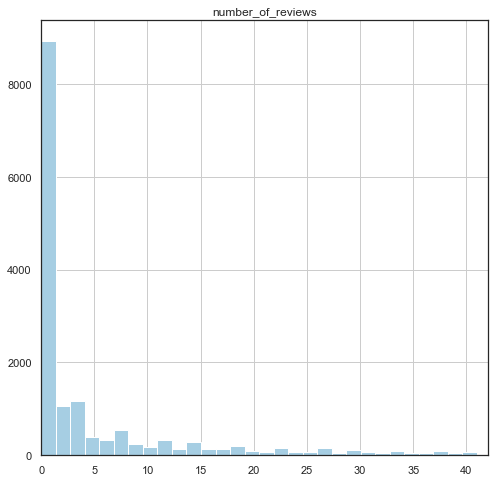

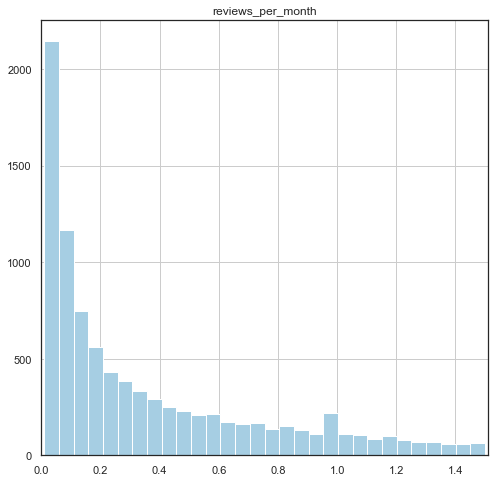

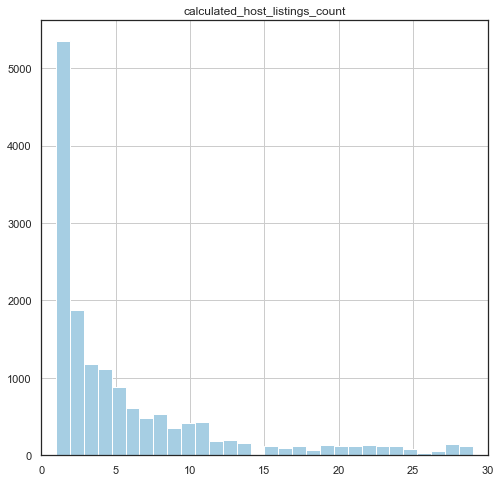

In [92]:
for col in ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count']:
    fig = plt.figure(figsize = (8,8))
    ax = fig.gca()
    filt = listings_summary_df.loc[listings_summary_df[col]< listings_summary_df[col].quantile([0.9]).values[0]][col]
    filt.hist(ax = ax, bins=30)
    ax.set_xlim(0,listings_summary_df[col].quantile([0.9]).values[0])
    ax.set_title(col)

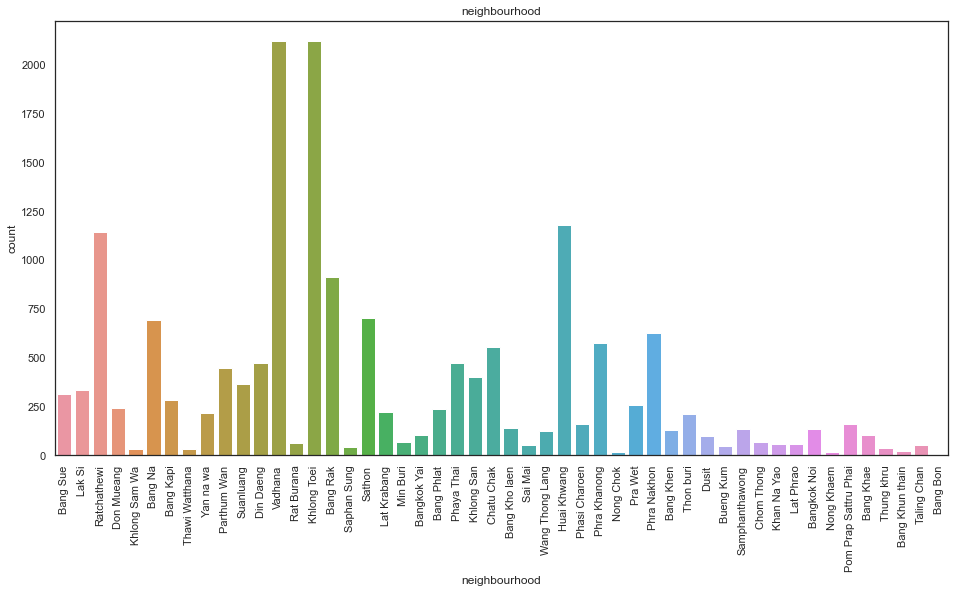

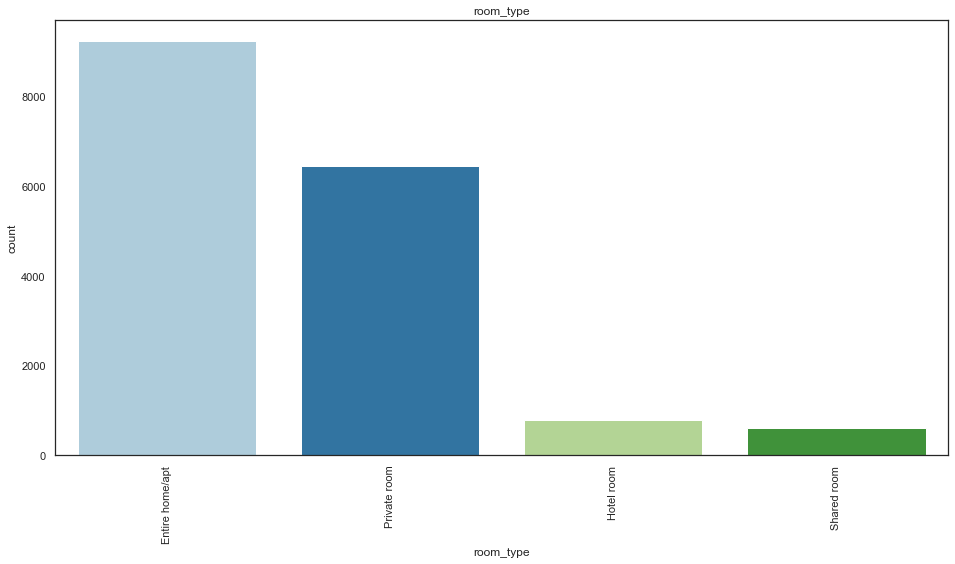

In [95]:
#cat features
for col in ['neighbourhood', 'room_type']:     
    fig = plt.figure(figsize = (16,8))
    ax = fig.gca()
    sns.countplot(x=listings_summary_df[col], ax=ax)
    ax.set_title(col)
    plt.xticks(rotation=90)

### Clean the data
Fix incorrect, incomplete, duplicate or otherwise erroneous data in a data set. For example, replace missing (null) values with average (if make sense), remove abnormal /duplicate data, and etc.

Handle character encoding with care in the text data, e.g., there might be different languages in the text.

When read (import) and write (export) files, if encoding is not specified, try set the encoding to utf-8. 

In [11]:
#remove duplicate from reviews_summary
reviews_summary_df = reviews_summary_df.drop_duplicates(subset = reviews_summary_df.columns.tolist(),ignore_index=True)

In [12]:
#drop empty columns

dfs = {'calendar': calendar_df,
      'listings':listings_df,
      'listings_summary': listings_summary_df,
      'reviews':reviews_df,
      'reviews_summary': reviews_summary_df}
for k,v in dfs.items():
    v.dropna(how='all', axis=1, inplace=True)
    v.to_csv('{}_cleaned.csv'.format(k), index = False, columns = v.columns.tolist())

In [13]:
# refresh data
calendar_df = pd.read_csv('calendar_cleaned.csv',  encoding="utf-8")
listings_df = pd.read_csv('listings_cleaned.csv',  encoding="utf-8")
listings_summary_df = pd.read_csv('listings_summary_cleaned.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews_cleaned.csv',  encoding="utf-8")
reviews_summary_df = pd.read_csv('reviews_summary_cleaned.csv',  encoding="utf-8")



dfs = {'Calendar': calendar_df,
      'Listings':listings_df,
      'Listings Summary': listings_summary_df,
      'Reviews':reviews_df,
      'Reviews Summary': reviews_summary_df}

for k,v in dfs.items():
    v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6231645 entries, 0 to 6231644
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 332.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17074 non-null  int64  
 1   listing_url                                   17074 non-null  object 
 2   scrape_id                                     17074 non-null  int64  
 3   last_scraped                                  17074 non-null  object 
 4  

### Data generation
For the Airbnb data and Yelp, generate some transaction records based on the actual data. For example, 
    
    Airbnb - bookings of rooms including e.g., date, number of days of stay, cost per day, total cost and etc.
    Yelp - bookings of restaurants including e.g., number of diners, cost, date and etc. 
The populated transaction data should meet the actual needs and conditions of the application. Based on this, 
    
    The transaction data should link the current data (add more connections). For example, if a user wrote a review for restaurant A on Oct 10 2022 on Yelp, you may generate a transaction at A for this user before or on the same day as the review post time (it may not be same as the actual date if mentioned in the review).

    Specify your assumptions when generating the data, e.g., based on 10% of the reviews or any other reasonable ways. 

    With the populated transaction data, focus on the database design to manage the data. 
    
    Information extraction (e.g., NER for price and exact date) from review text is NOT required for data generation. 

In [24]:
# refresh data
calendar_df = pd.read_csv('calendar_cleaned.csv',  encoding="utf-8")
listings_df = pd.read_csv('listings_cleaned.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews_cleaned.csv',  encoding="utf-8")
customers_df = pd.read_csv('customers.csv',  encoding="utf-8")
transactions_df = pd.read_csv('transactions.csv',  encoding="utf-8")

In [16]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [18]:
host_df = listings_df[['host_id', 'host_name', 'host_url', 'host_since','host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood','host_has_profile_pic','host_identity_verified','host_verifications']].copy()

In [25]:
listings_df = listings_df[['id','listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
                'neighborhood_overview', 'picture_url', 'host_id','neighbourhood','neighbourhood_cleansed',
                'latitude', 'longitude', 'property_type','room_type', 'accommodates', 'bathrooms_text', 
                'bedrooms', 'beds', 'calendar_last_scraped', 'review_scores_rating', 'review_scores_accuracy',
                'review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location',
                'review_scores_value', 'instant_bookable']]

### Queries

Show the listings available for booking from X date for Y days. User can select optional filters (can just demonstrate three as example?):​

	Accommodates X people​

	Price within X range (total price for that period, referencing calendar table)​

	Review score rating greater than X​

	Property type​

	Etc.​

Demonstrate join with host table:​

	Show the listings where the host is a superhost​

	Demonstrate join with amenities table:​

	e.g. Show the listings with WiFi​

Demonstrate join with reviews table:​

	Show the reviews for listing X​
  
5. Average Check in/ average price past 12 months for certain listings​

6. Calculate total listings of certain host​

7. total revenue of a certain host for certain period (transaction join listing join host)​

8. find listings with at least one review (review score ratings is not null)



#### transforming calendar by dates, group by listing id, for embedded documents, merge to listings using listing id
listing_id : "dates":[{"date" : "2022-06-20",
                      "available": "t",
                      "price": 890,
                      "adjusted_price": 890,
                      "minimum_nights": 1,
                      "maximum_nights": 365,
                      }]

In [62]:
def concatstring(list1, cols):
    string = "[{"
    for i,item in enumerate(list1):
        string = string + "\"" + cols[i] + "\" : " + "\"" + str(item) + "\","
    string = string + "}]"
    return string

In [69]:
cols = calendar_df.columns.tolist()
cols.remove('listing_id')
calendar_df['dates'] = calendar_df.apply(lambda x: concatstring([x.date, 
                                                                 x.available, 
                                                                 x.price, 
                                                                 x.adjusted_price, 
                                                                 x.minimum_nights, 
                                                                 x.maximum_nights],cols), axis = 1)

In [73]:
calendar_df.to_csv('calendar_df_transformed.csv', index = False, columns = calendar_df.columns.tolist())

####  transforming host by host ids, merge to listings using host_id

In [74]:
host_df.columns.tolist()

['host_id',
 'host_name',
 'host_url',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_verifications']

In [76]:
cols = host_df.columns.tolist()
host_df['hosts'] = host_df.apply(lambda x: concatstring([x.host_id,
                                                        x.host_name,
                                                        x.host_url,
                                                        x.host_since,
                                                        x.host_location,
                                                        x.host_about,
                                                        x.host_response_time,
                                                        x.host_response_rate,
                                                        x.host_acceptance_rate,
                                                        x.host_is_superhost,
                                                        x.host_thumbnail_url,
                                                        x.host_picture_url,
                                                        x.host_neighbourhood,
                                                        x.host_has_profile_pic,
                                                        x.host_identity_verified,
                                                        x.host_verifications],cols), axis = 1)

In [78]:
host_df.to_csv('host_df_transformed.csv', index = False, columns = host_df.columns.tolist())

#### merge review and transaction and customer, then transform by reviewer ids, merge to listings using listing_id

In [134]:
transactions_df = pd.read_csv('transactions.csv',  encoding="utf-8")
reviews_df = pd.read_csv('reviews_cleaned.csv',  encoding="utf-8")
customers_df = pd.read_csv('customers.csv',  encoding="utf-8")

In [135]:
reviews_df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [136]:
transactions_df.columns

Index(['review_id', 'listing_id', 'customer_id', 'review_date',
       'customer_name', 'transaction_id', 'check_out_date', 'length_of_stay',
       'check_in_date', 'transaction_date', 'cost_per_day', 'total_cost',
       'number_of_guests', 'cancelled_transaction', 'refund_percentage'],
      dtype='object')

In [137]:
customers_df.columns

Index(['customer_id', 'customer_name', 'phone', 'email'], dtype='object')

In [138]:
reviews_df = reviews_df.merge(transactions_df, left_on = ['id', 'listing_id'], right_on = ['review_id','listing_id'], how = 'left')

In [139]:
reviews_df = reviews_df.merge(customers_df,on = ['customer_id', 'customer_name'], how = 'left')

In [140]:
reviews_df.columns.tolist()

['listing_id',
 'id',
 'date',
 'reviewer_id',
 'reviewer_name',
 'comments',
 'review_id',
 'customer_id',
 'review_date',
 'customer_name',
 'transaction_id',
 'check_out_date',
 'length_of_stay',
 'check_in_date',
 'transaction_date',
 'cost_per_day',
 'total_cost',
 'number_of_guests',
 'cancelled_transaction',
 'refund_percentage',
 'phone',
 'email']

In [130]:
cols = reviews_df.columns.tolist()
cols.remove('listing_id')
cols.remove('id')
reviews_df['reviewers'] = reviews_df.apply(lambda x: concatstring([x.date,
                                                                   x.reviewer_id,
                                                                   x.reviewer_name,
                                                                   x.comments,
                                                                   x.review_id,
                                                                   x.customer_id,],cols), axis = 1)

In [133]:
cols

['date',
 'reviewer_id',
 'reviewer_name',
 'comments',
 'review_id',
 'customer_id',
 'review_date',
 'customer_name',
 'transaction_id',
 'check_out_date',
 'length_of_stay',
 'check_in_date',
 'transaction_date',
 'cost_per_day',
 'total_cost',
 'number_of_guests',
 'cancelled_transaction',
 'refund_percentage',
 'phone',
 'email']

### Queries 2

Customers​

    Longest length of stay​

    Listing with certain amenities​

    Listings between certain prices​

    Cheapest superhost listings that are available, including of service fee​

​

Airbnb data analyst​

    Neighborhood with worst/best review​

    Neighborhood with highest/lowest number of listings​

    Listings/neighborhood with lowest/highest rate of cancellation​

In [132]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments,review_id,customer_id,review_date,customer_name,...,check_in_date,transaction_date,cost_per_day,total_cost,number_of_guests,cancelled_transaction,refund_percentage,phone,email,reviewers
0,39544047,564106023,2019-11-15,273940743,Kim,"Good communication, basic and clean accommodation",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""273940743"",""reviewer_id"" : ""2019-1..."
1,39544047,566622127,2019-11-20,143251478,Oliver,"Good, clean, cheap accomodation in proximity t...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""143251478"",""reviewer_id"" : ""2019-1..."
2,39544047,568138380,2019-11-24,288635322,Doris,"A nice room, very close to impact arena, also ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""288635322"",""reviewer_id"" : ""2019-1..."
3,39544047,568816394,2019-11-24,163790201,Yang,The landlord sister is really kind and lovely....,568816394.0,163790201.0,2019-11-24,Yang,...,2019-10-23,2019-10-05,642.0,13482.0,1.0,f,0.0,63346726.0,Yang6334@gmail.com,"[{""date"" : ""163790201"",""reviewer_id"" : ""2019-1..."
4,39544047,597651173,2020-01-26,317920443,Kunat,"The room was very new, cleand and well funishe...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""317920443"",""reviewer_id"" : ""2020-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249127,25650511,546028757839670443,2022-01-23,9395774,Michael,Great place! Loved the gym and the pool. LOVED...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""9395774"",""reviewer_id"" : ""2022-01-..."
249128,25650511,575030942853820235,2022-03-04,112523712,Akira,綺麗に整理整頓されており食器類あり必要なものはすべて揃っています窓からの眺めもいいです おす...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""112523712"",""reviewer_id"" : ""2022-0..."
249129,25650511,580846849788103547,2022-03-12,301320803,Xylis,"Frank was very kind and patient, I am so happy...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""301320803"",""reviewer_id"" : ""2022-0..."
249130,25650511,619167599448170428,2022-05-04,453549937,Premkamon,"The place exactly the same as photos, very nic...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""date"" : ""453549937"",""reviewer_id"" : ""2022-0..."
